# Examples for paper draft "TTR goes to the SPA"

In [1]:
import nengo
import nengo_spa as spa
import numpy as np
import matplotlib.pyplot as plt

These libraries are used for all examples. 
Apart from that, each example can be run on its own.
For obtaining and using the Nengo libraries see https://www.nengo.ai/.

## F structure
### unbind type of object

In [5]:
d = 64
with spa.Network("F") as f:
    f_state = spa.State(vocab=d)
    query = spa.State(vocab=d)
    
    spa.sym("(IND * (A + B + C)) + (INT * (ONE + TWO + THREE))") >> f_state
    f_state * spa.sym("~A") >> query
    
    p = nengo.Probe(query.output, synapse=0.01)

In [6]:
with nengo.Simulator(f) as sim:
    sim.run(0.5)

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

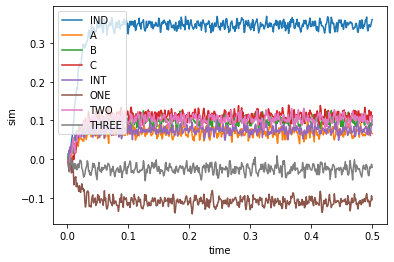

In [7]:
plt.figure()
plt.plot(sim.trange(), spa.similarity(sim.data[p], query.vocab))
plt.xlabel("time")
plt.ylabel("sim")
plt.legend(query.vocab, loc="best")

### does unbinding of type AND object equals 1?
(no, it does not)

In [12]:
d = 64
vocab = spa.Vocabulary(dimensions=d)
vocab.populate(
    """
    A; B; C; 
    ONE; TWO; THREE; 
    IND; INT; 
    F = (IND * (A + B + C)) + (INT * (ONE + TWO + THREE))"""
)

In [13]:
# A : IND ∼ F * IND' * A' ≈ 1
pointer_a_ind = vocab.parse("F * ~IND * ~A").v

In [14]:
print(pointer_a_ind)

[ 0.5303104  -0.00773001 -0.252485    0.50239845  0.72432385 -0.22966053
 -0.32171623  0.70729237  0.72940146 -0.49047744 -0.19981664  0.17164761
  0.19486293 -0.44149278 -0.84047377  0.30945821  0.52105218 -0.3441509
 -0.14961033  0.4749769   0.21654596 -0.73205105 -0.54806367 -0.07460593
  0.35675571 -0.49041847 -0.54446126  0.46843815  0.38447847 -0.5409123
 -0.06668394  0.24190771  0.09675067 -0.42236833 -0.30338849  0.23846253
  0.12329922 -0.40542775 -0.20540934  0.45261996 -0.09877059 -0.63519232
 -0.34306971 -0.22244486  0.06778307 -0.14183507 -0.31879915 -0.03578718
  0.41567954 -0.26547767 -0.35285008 -0.13928073  0.03853346 -0.2701695
 -0.40871635  0.13733399  0.79890285  0.29978908 -0.41829641  0.49647811
  0.94152692 -0.121617   -0.26170147  0.00116182]


## S + S = S for all SPA
### similarity based

In [6]:
d = 64
vocab = spa.Vocabulary(dimensions=d)
vocab.populate("A; B; S")

with spa.Network(label="S+S") as model:
    simple = spa.Transcode(lambda t: "A" if t < 0.25 else "B" if t < 0.5 else "S", output_vocab=d)
    test = spa.Transcode(lambda t: 
                         "(A+A).normalized()" if t < 0.25 
                         else "(B+B).normalized()" 
                         if t < 0.5 else "(S+S).normalized()", output_vocab=d)
    # compare to non-normalized bundling: 
    # test = spa.Transcode(lambda t: "A+A" if t < 0.25 else "B+B" if t < 0.5 else "S+S", output_vocab=d)out_test = spa.State(vocab=d)
    out_simple = spa.State(vocab=d)
    out_test = spa.State(vocab=d)
    
    test >> out_test
    simple >> out_simple
    
    p_test = nengo.Probe(out_test.output, synapse=0.01)
    p_simple = nengo.Probe(out_simple.output, synapse=0.01)

In [7]:
with nengo.Simulator(model) as sim:
    sim.run(0.75)

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

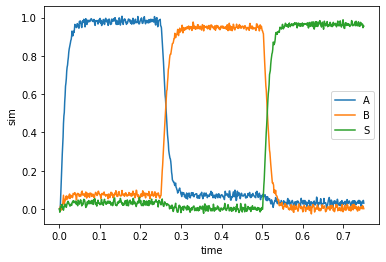

In [8]:
plt.figure()
plt.plot(sim.trange(), spa.similarity(sim.data[p_simple], out_simple.vocab))
plt.xlabel("time")
plt.ylabel("sim")
plt.legend(out_simple.vocab, loc="best")

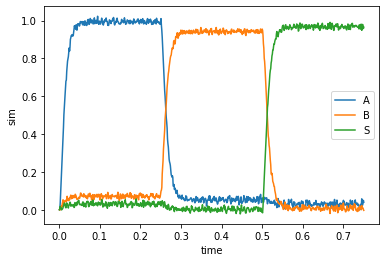

In [9]:
plt.figure()
plt.plot(sim.trange(), spa.similarity(sim.data[p_test], out_test.vocab))
plt.xlabel("time")
plt.ylabel("sim")
plt.legend(out_test.vocab, loc="best")

### vector based

In [5]:
d = 64
vocab = spa.Vocabulary(dimensions=d)
vocab.populate("A; B; S")

# Caution! The two vectors may differ in their number of decimal places! 
# For comarison, round them to, say, 10 decimal places:
pointer_aa = np.round(vocab.parse("(A+A).normalized()").v, 10)
pointer_a = np.round(vocab["A"].v, 10)

# pointer_bb = vocab.parse("(B+B).normalized()").v
# pointer_ss = vocab.parse("(S+S).normalized()").v

In [50]:
# inspect first dimension of result:
print(pointer_aa[0])
print(pointer_a[0])

-0.0552601866
-0.0552601866


In [52]:
# comparing vectors with any():
if (pointer_aa==pointer_a).any():
    print("Pointer \"A\" is identical to pointer \"A+A\"")
else:
    print("pointers differ")

Pointer "A" is identical to pointer "A+A"


In [53]:
# Comparing vectors with numpy's arrays_equal()
if np.array_equal(pointer_aa, pointer_a):
    print("Equal")
else:
    print("Not Equal")

Equal


## Binding distributes over bundling

In [58]:
d = 64
vocab = spa.Vocabulary(dimensions=d)
vocab.populate("A; B; C")

pointer_bundle = np.round(vocab.parse("A * B + A * C").v, 10)
pointer_distrib = np.round(vocab.parse("A * (B + C)").v, 10)

In [59]:
if np.array_equal(pointer_bundle, pointer_distrib):
    print("equal")
else:
    print("different")

equal


# Singleton types

In [41]:
d = 64
vocab = spa.Vocabulary(dimensions=d)
vocab.populate("A; T; B; B_EQ_A = A")

def rehearsal(t):
    if t < 0.25:
        return "T + A"
    elif t < 0.5:
        return "T + B"
    else:
        return "T + B_EQ_A"
    
with spa.Network("Singletons") as model:
    out = spa.State(vocab=vocab)
    query = spa.Transcode(rehearsal, output_vocab=vocab)
    
    query >> out
    
    p = nengo.Probe(out.output, synapse=0.01)

In [42]:
with nengo.Simulator(model) as sim:
    sim.run(1)

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

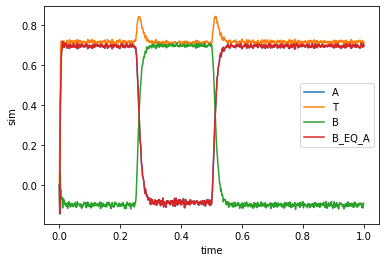

In [47]:
plt.figure()
plt.plot(sim.trange(), spa.similarity(sim.data[p], out.vocab, normalize=True))
plt.xlabel("time")
plt.ylabel("sim")
plt.legend(out.vocab, loc="best")

# Paths
bind type t2 to t1 by a path of three labels: t1 * l1 * l2 * l3 : t2

In [8]:
d = 64
vocab = spa.Vocabulary(dimensions=d)
vocab.populate("T1; T2; L1; L2; L3; L4; T3 = (T1 * L1 * L2 * L3 * L4 * T2)")

with spa.Network("Paths") as model:
    out = spa.State(vocab=d)
    query = spa.Transcode(lambda t: 
                          "T3 * ~T1 * ~L1 * ~L2 * ~L3 * ~L4" if t < 0.25 
                          else "T2", output_vocab=d)
    
    # spa.sym("T3 * ~T1 * ~L1 * ~L2 * ~L3 * ~L4") >> out
    query >> out
    
    p = nengo.Probe(out.output, synapse=0.01)

In [9]:
with nengo.Simulator(model) as sim:
    sim.run(0.5)

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

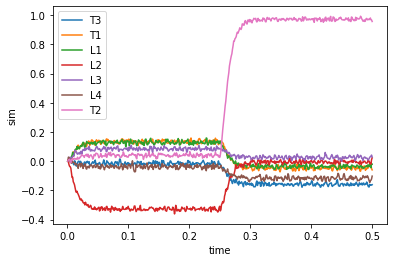

In [10]:
plt.figure()
plt.plot(sim.trange(), spa.similarity(sim.data[p], out.vocab))
plt.xlabel("time")
plt.ylabel("sim")
plt.legend(out.vocab, loc="best")

## S * S' = 1

In [72]:
d = 32
vocab = spa.Vocabulary(dimensions=d)
vocab.populate("S")

s_vec = np.round(vocab["S"].v, 10)
inverse_vec = np.round(vocab.parse("~S").v, 10)
bind_vec = np.round(vocab.parse("S * ~S").v, 10)

In [75]:
print("S:\n", s_vec)
print("inverse:\n", inverse_vec)
print("bind:\n", bind_vec)

S:
 [ 0.03863399 -0.25934266  0.16899501 -0.0723031  -0.11588228  0.03697957
 -0.19478691  0.20101748  0.2187074  -0.14665103  0.00836047  0.02063776
  0.41098485  0.17467461 -0.22426568 -0.07927497 -0.22331247 -0.09189492
 -0.12800697 -0.26441462  0.04552998  0.18912929 -0.02518073  0.2084058
 -0.07980221 -0.08041494 -0.05554016  0.29819032  0.0791536   0.03261032
 -0.14339871 -0.34529403]
inverse:
 [ 0.03863399 -0.34529403 -0.14339871  0.03261032  0.0791536   0.29819032
 -0.05554016 -0.08041494 -0.07980221  0.2084058  -0.02518073  0.18912929
  0.04552998 -0.26441462 -0.12800697 -0.09189492 -0.22331247 -0.07927497
 -0.22426568  0.17467461  0.41098485  0.02063776  0.00836047 -0.14665103
  0.2187074   0.20101748 -0.19478691  0.03697957 -0.11588228 -0.0723031
  0.16899501 -0.25934266]
bind:
 [ 1.          0.06715081 -0.01411307 -0.13693478 -0.23050322  0.25170035
 -0.17120821 -0.14446384 -0.13575514 -0.23785251  0.02486284 -0.04690112
 -0.03543558  0.01174734 -0.05685212  0.27466801  0.3

In [90]:
# numpy:
dot_prod = np.dot(s_vec, inverse_vec)
# since Python 3.5:
dot_new = s_vec @ inverse_vec
# spa:
dot_spa_norm = spa.similarity(s_vec, inverse_vec, normalize=True)

print(dot_prod)
print(dot_new)
print(dot_spa_norm)

0.09868243105554851
0.09868243105554851
[0.09868243]


## Subtypes

In [48]:
d = 64
vocab = spa.Vocabulary(dimensions=d)
vocab.populate("L1; L2; T1; T2")

supertype = np.round(vocab.parse("L1 * T1").v, 10)
subtype = np.round(vocab.parse("L1 * T1 + L2 * T2").v, 10)

sim_base = spa.similarity(subtype,subtype,normalize=True)
sim_norm = spa.similarity(supertype,subtype,normalize=True)

print("Identity:", sim_base)
print("Sim:", sim_norm)

sim_max = spa.similarity(np.maximum(supertype,subtype),subtype,normalize=True)
print("Sim max:", sim_max)

Identity: [1.]
Sim: [0.65160681]
Sim max: [0.8314121]
